# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

# Введение

Заказчик исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


**Бизнес-метрика и другие данные**

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:
    
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


## Импортируем библиотеки и задаем константы

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score

In [5]:
from pandas.api.types import is_integer_dtype

In [6]:
# pd.set_option('max_columns', None)

In [7]:
RANDOM_STATE = 12345
FIGSIZE_FOR_SINGLE_PLOT = (9, 6)
FIGSIZE_FOR_BUNCH_OF_PLOTS = (12, 15)

In [8]:
# стоимость номеров отеля по категориям
PRICES = {
    'A' : 1000,
    'B' : 800,
    'C' : 600,
    'D' : 550,
    'E' : 500,
    'F' : 450,
    'G' : 350,
}

In [9]:
# стоимость разового обслуживания номеров отеля по категориям
ONE_TIME_SERVICE = {
    'A' : 400,
    'B' : 350,
    'C' : 350,
    'D' : 150,
    'E' : 150,
    'F' : 150,
    'G' : 150,
}

In [10]:
# сезонный коэффициент
SEASONAL_COEFFICIENT = {
    'spr_aut': 1.2,
    'summer': 1.4,
    'winter': 1
}

# процент для суммы депозита
DEPOSIT_PERCENT = 0.8

In [11]:
# порядковые номера месяцев в году
MONTH_CODES = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

## Шаг 1. Откройте файлы с данными

### Выгрузка данных из файлов

Откроем файлы с обучающей и тестовой выборками и проведём первичный анализ данных.

In [12]:
hotel_train = pd.read_csv('datasets/hotel_train.csv')
hotel_test = pd.read_csv('datasets/hotel_test.csv')

In [13]:
def first_look(df, lines=5):
    '''выводит основные показатели для набора данных
    Принимает следующие параметры:
    df - набор данных
    lines - количество строк для вывода
    '''
    print(f'Первые строки ({lines} шт):')
    print(df.head(lines))
    print()
    print('Общее описание набора данных:\n')
    print(df.info())
    print()
    print('Наличие пропусков в данных:\n')
    print(df.isna().sum())
    print()
    print('Наличие дубликатов в данных:', df.duplicated().sum())

In [14]:
first_look(hotel_train)

Первые строки (5 шт):
   id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0   0            0        7.0               2015               July   
1   1            0       14.0               2015               July   
2   2            0        0.0               2015               July   
3   3            0        9.0               2015               July   
4   4            1       85.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     1     1.0  ...   
1                        0                     2     2.0  ...   
2      

In [15]:
first_look(hotel_test)

Первые строки (5 шт):
     id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  6086            1       74.0               2017            January   
1  6087            1       62.0               2017            January   
2  6088            1       62.0               2017            January   
3  6089            1       71.0               2017            January   
4  6090            1      172.0               2017            January   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         1                          1   
1                         1                          1   
2                         1                          1   
3                         1                          1   
4                         1                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        1                     0     2.0  ...   
1                        2                     2     2.0  ..

In [16]:
# соотношение обучающей и тестовой выборок
hotel_train.shape[0] / hotel_test.shape[0]

2.012495372084413

Проверим наличие полных дубликатов без столбца id.

In [17]:
print(
    'Наличие дубликатов в данных:', 
    hotel_train.drop('id', axis=1).duplicated().sum()
)

Наличие дубликатов в данных: 21377


Удалим их.

In [18]:
# столбцы для поиска дубликатов
columns = list(hotel_train.columns)[1:]
columns

['is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'booking_changes',
 'days_in_waiting_list',
 'customer_type',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'total_nights']

In [19]:
hotel_train.drop_duplicates(
    subset=columns, 
    keep='first',
    inplace=True,
    ignore_index=True
)

In [20]:
print(
    'Наличие дубликатов в данных:', 
    hotel_train.drop('id', axis=1).duplicated().sum()
)

Наличие дубликатов в данных: 0


In [21]:
hotel_train.shape

(43852, 25)

Проверим наличие полных дубликатов без столбца id  в тестовой выборке.

In [22]:
print(
    'Наличие дубликатов в данных:', 
    hotel_test.drop('id', axis=1).duplicated().sum()
)

Наличие дубликатов в данных: 7717


In [23]:
hotel_train.head(20)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3
5,5,1,75.0,2015,July,27,1,0,3,2.0,...,0,0,0,D,0,0,Transient,0,0,3
6,6,1,23.0,2015,July,27,1,0,4,2.0,...,0,0,0,E,0,0,Transient,0,0,4
7,7,0,18.0,2015,July,27,1,0,4,2.0,...,0,0,0,G,1,0,Transient,0,1,4
8,8,0,68.0,2015,July,27,1,0,4,2.0,...,0,0,0,D,0,0,Transient,0,3,4
9,9,0,37.0,2015,July,27,1,0,4,2.0,...,0,0,0,E,0,0,Contract,0,0,4


Удалим эти строки, потому что их присутствие не позволит корректно рассчитать прибыль отеля и оценить полезность использования модели.

In [24]:
hotel_test.drop_duplicates(
    subset=columns, 
    keep='first',
    inplace=True,
    ignore_index=True
)

In [25]:
print(
    'Наличие дубликатов в данных:', 
    hotel_test.drop('id', axis=1).duplicated().sum()
)

Наличие дубликатов в данных: 0


In [26]:
hotel_test.shape

(24695, 25)

### Вывод

Обучающая и тестовая выборки изначально содержали 65229 и 32412 строк соответственно. 

После удаления дубликатов - 43852 и 24695 строк.

В каждой выборке содержится номер записи ('id') и 24 характеристики объекта. 


## Шаг 2. Предобработка и исследовательский анализ данных

Данные требуют предварительной обработки. Будем проводить ее для обоих наборов данных параллельно, чтобы к тому моменту, когда они будут переданы модели, они имели одинаковую структуру.

### Приведение типов столбцов

Столбцы 'lead_time', 'adults', 'children', 'babies' содержат целые числа, поэтому приведем их к типу int

In [27]:
# для обучающей выборки
hotel_train[['lead_time', 'adults', 'children', 'babies']] =\
hotel_train[['lead_time', 'adults', 'children', 'babies']].astype('int')
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7,2015,July,27,1,0,1,1,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14,2015,July,27,1,0,2,2,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0,2015,July,27,1,0,2,2,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9,2015,July,27,1,0,2,2,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85,2015,July,27,1,0,3,2,...,0,0,0,A,0,0,Transient,0,1,3


In [28]:
# для тестовой выборки
hotel_test[['lead_time', 'adults', 'children', 'babies']] =\
hotel_test[['lead_time', 'adults', 'children', 'babies']].astype('int')
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74,2017,January,1,1,1,0,2,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62,2017,January,1,1,2,2,2,...,0,0,0,A,0,0,Transient,0,1,4
2,6089,1,71,2017,January,1,1,2,2,1,...,0,0,0,A,0,0,Transient,0,1,4
3,6090,1,172,2017,January,1,1,2,5,2,...,0,0,0,A,0,0,Transient,0,0,7
4,6091,1,52,2017,January,1,1,2,5,1,...,0,0,0,A,0,0,Transient,0,0,7


### Преобразование названия месяца в число

Переведем столбец с названиями месяцев из строкового в числовой. Для этого заменим имена месяцев их порядковым номером в году, затем полученный столбец приведем у целочисленному типу.

In [29]:
# для обучающей выборки
# до преобразования
hotel_train['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [30]:
# заменяем название месяца его порядковым номером
for month in MONTH_CODES.keys():
    hotel_train.loc[hotel_train['arrival_date_month']==month, 'arrival_date_month'] =\
    MONTH_CODES[month]

hotel_train['arrival_date_month'].astype('int32')
# после преобразования
hotel_train['arrival_date_month'].unique()

array([7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6], dtype=object)

In [31]:
# для тестовой выборки
# до преобразования
hotel_test['arrival_date_month'].unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

In [32]:
# заменяем название месяца его порядковым номером
for month in MONTH_CODES.keys():
    hotel_test.loc[hotel_test['arrival_date_month']==month, 'arrival_date_month'] =\
    MONTH_CODES[month]

hotel_test['arrival_date_month'].astype('int32')

# после преобразования
hotel_train['arrival_date_month'].unique()

array([7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6], dtype=object)

### Обработка столбца с типом номера отеля

Теперь изучим столбец с данными о типе номера отеля

In [33]:
# для обучающей выборки
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [34]:
# для тестовой выборки
hotel_test['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

Видим, что встречаются типы номеров, которые нам передали в описании дынных. Но в строках, содержащих информацию о типе комнаты, добавлено много пробелов. Почистим их, оставив только первый символ.

In [35]:
# для обучающей выборки
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip()

# для тестовой выборки
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip()


Посмотрим на результат преобразования.

In [36]:
hotel_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [37]:
hotel_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

### Обработка столбца с опциями заказа

Изучим содержимое столбца meal.

In [38]:
# для обучающей выборки
print(
    'В столбце "meal"', 
    len(hotel_train['meal'].unique()), 
    'уникальных значений:')
print(sorted(hotel_train['meal'].unique()))

В столбце "meal" 5 уникальных значений:
['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']


In [39]:
# для тестовой  выборки
print(
    'В столбце "meal"', 
    len(hotel_test['meal'].unique()), 
    'уникальных значений:')
print(sorted(hotel_test['meal'].unique()))

В столбце "meal" 5 уникальных значений:
['BB       ', 'FB       ', 'HB       ', 'SC', 'SC       ']


В столбце meal есть дубликаты, так как добавлены лишние пробелы. Удалим эти пробелы также, как в случае с типом номера отеля.

In [40]:
# для обучающей выборки
hotel_train['meal'] = hotel_train['meal'].str.strip()


# для тестовой выборки
hotel_test['meal'] = hotel_test['meal'].str.strip()

Посмотрим на результат преобразования.

In [41]:
hotel_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [42]:
hotel_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

### Анализ выбросов

Чтобы проанализировать наличие выбросов, изучим гистограммы числовых характеристик наборов данных.

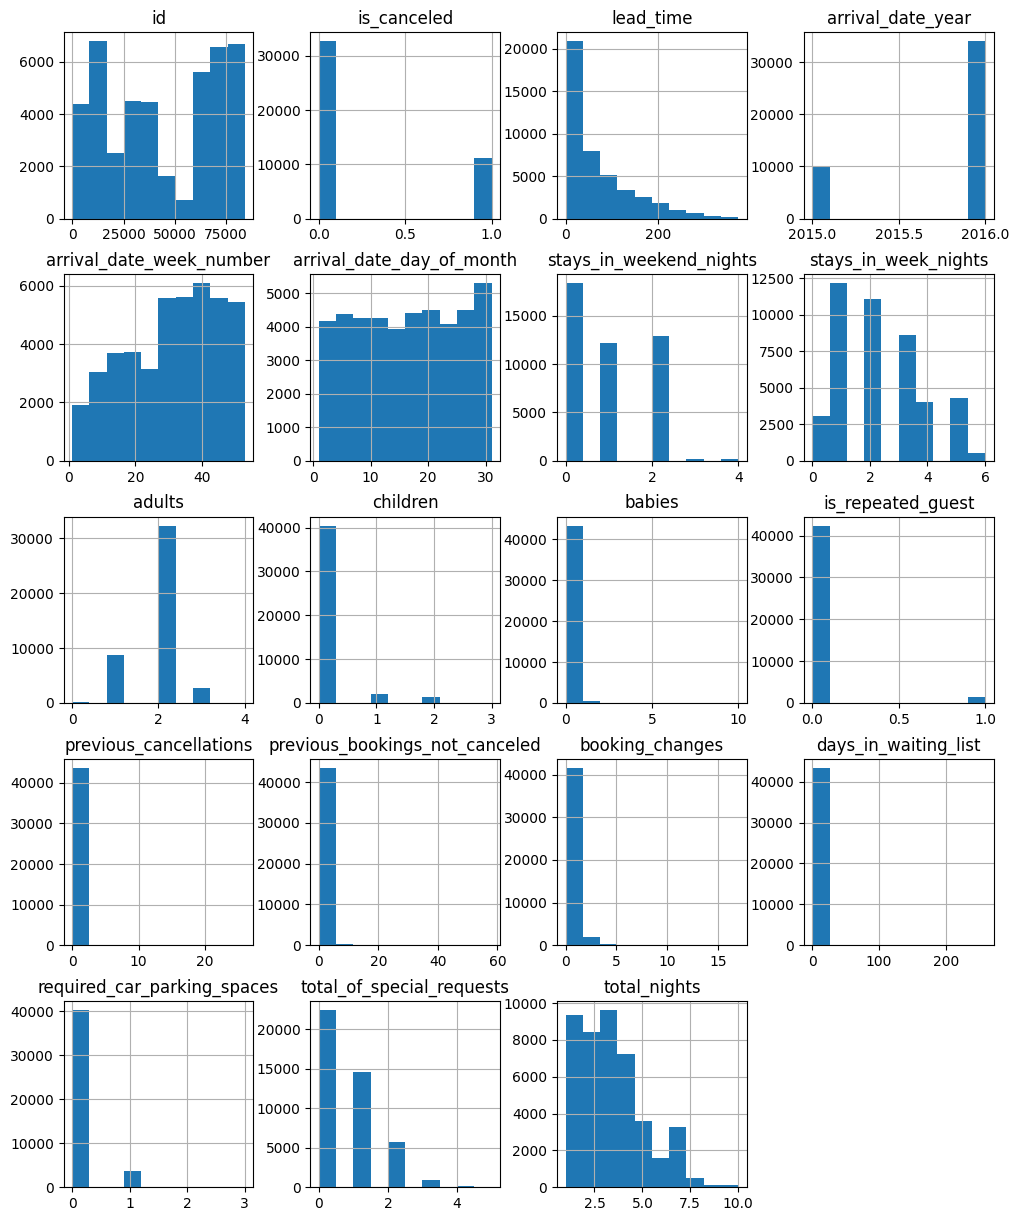

In [43]:
# для обучающей выборки
hotel_train.hist(
    figsize=FIGSIZE_FOR_BUNCH_OF_PLOTS
);

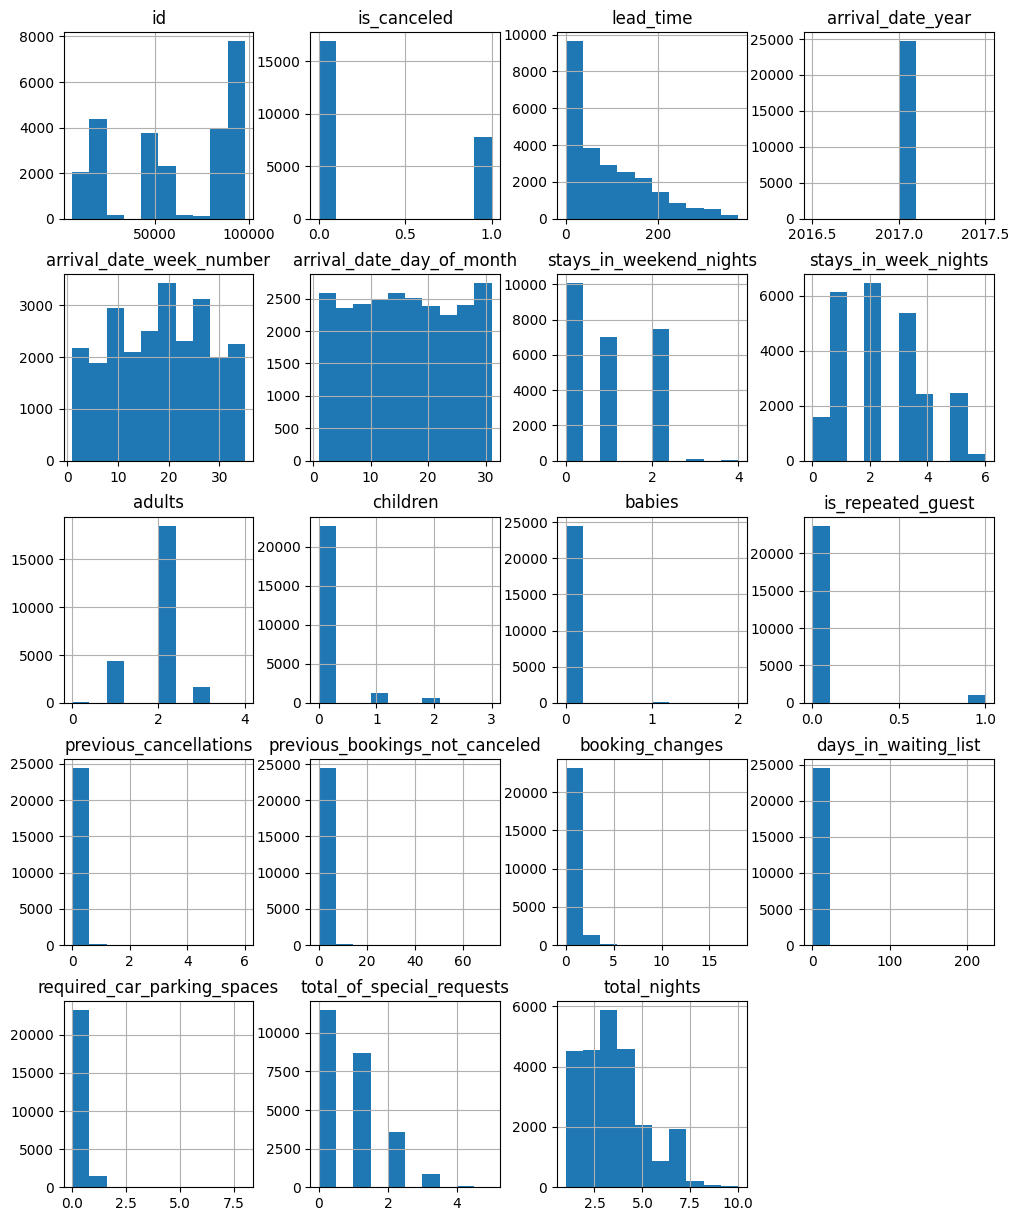

In [44]:
# для тестовой  выборки
hotel_test.hist(
    figsize=FIGSIZE_FOR_BUNCH_OF_PLOTS
);

Подробнее рассмотрим те столбцы, гистограммы которых имеют пик вблизи начала координат и сходят на нет при удалении от него.

##### Количество изменений параметров заказа

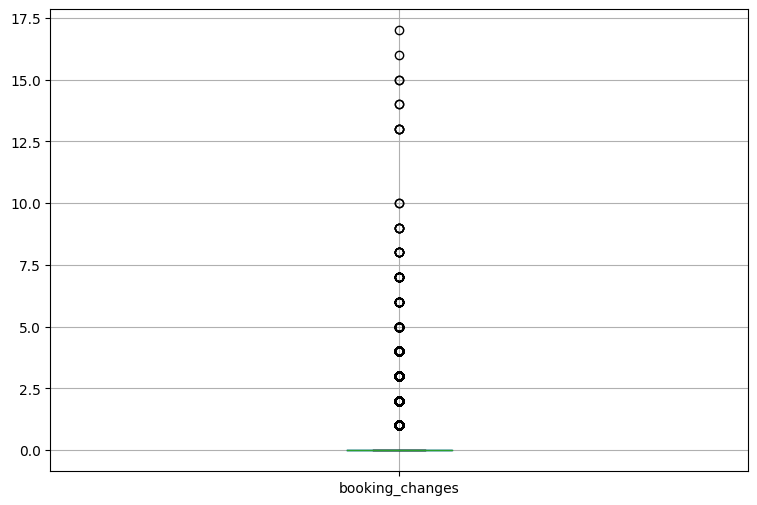

In [45]:
# для обучающей выборки
hotel_train.boxplot(
    column='booking_changes',
    figsize=FIGSIZE_FOR_SINGLE_PLOT);

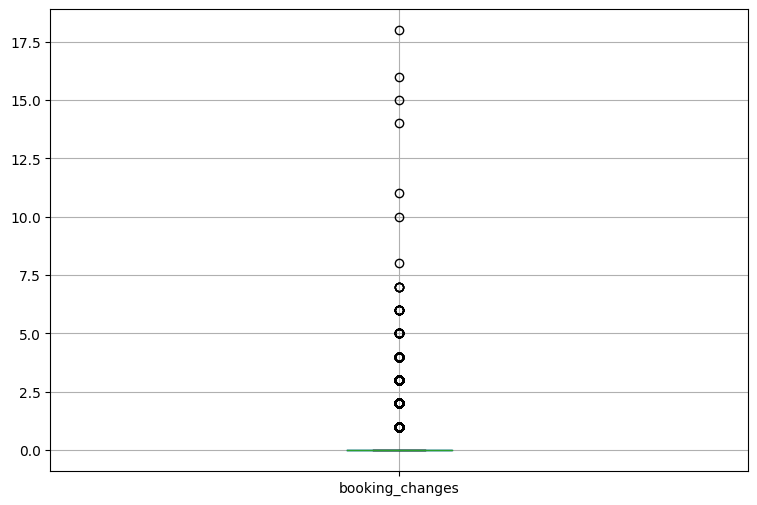

In [46]:
# для тестовой выборки
hotel_test.boxplot(
    column='booking_changes',
    figsize=FIGSIZE_FOR_SINGLE_PLOT);

In [47]:
# процент от общего числа строк
# для обучающей выборки
hotel_train[hotel_train['booking_changes'] > 2]['id'].count() / hotel_train.shape[0] * 100

1.4092857794399343

In [48]:
# процент от общего числа строк
# для тестовой выборки
hotel_test[hotel_test['booking_changes'] > 2]['id'].count() / hotel_test.shape[0] * 100

1.6845515286495243

Из гистограммы и boxplot столбца booking_changes обеих выборок видно, что значения, большие 2 относятся к выбросам. Количество таких строк составляет всего около 1,5% от имеющихся  данных. 

Видим, что диапазон значений столбца booking_changes одинаковый для обоих выборок, а значит, это не ошибки данных, а значения, которые могут встречаться и после запуска модели в работу.  Не будем удалять эти строки, потому что модель должна уметь работать с такими данными.


##### Количество дней ожидания подтверждения

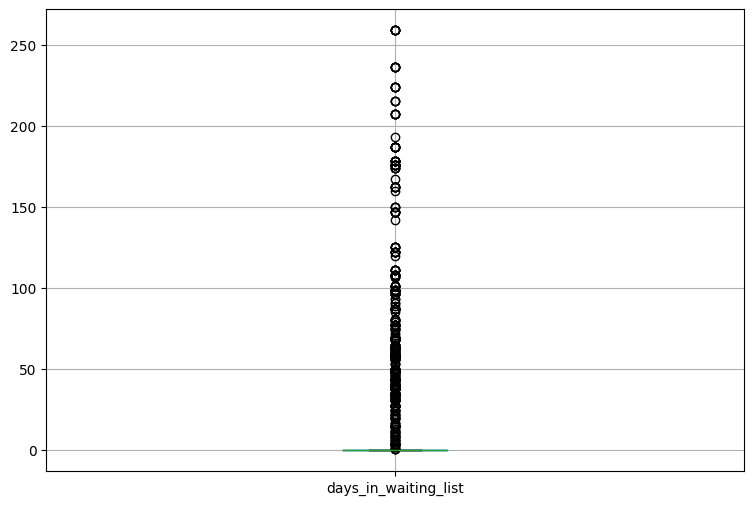

In [49]:
# для обучающей выборки
hotel_train.boxplot(
    column='days_in_waiting_list',
    figsize=FIGSIZE_FOR_SINGLE_PLOT);

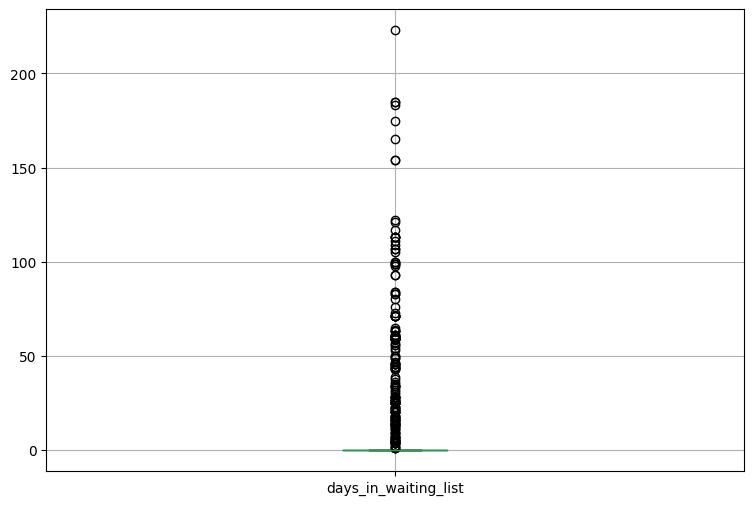

In [50]:
# для тестовой выборки
hotel_test.boxplot(
    column='days_in_waiting_list',
    figsize=FIGSIZE_FOR_SINGLE_PLOT);

In [51]:
# процент от общего числа строк
# для обучающей выборки
hotel_train[hotel_train['days_in_waiting_list'] > 100]['id'].count() / hotel_train.shape[0] * 100

0.24856334944814376

In [52]:
# процент от общего числа строк
# для тестовой выборки
hotel_test[hotel_test['days_in_waiting_list'] > 100]['id'].count() / hotel_test.shape[0] * 100

0.08098805426199635

Здесь ситуация аналогичная, оставляем данные, характеристики которых отличаются от большинства. 

##### Количество отменённых заказов у клиента

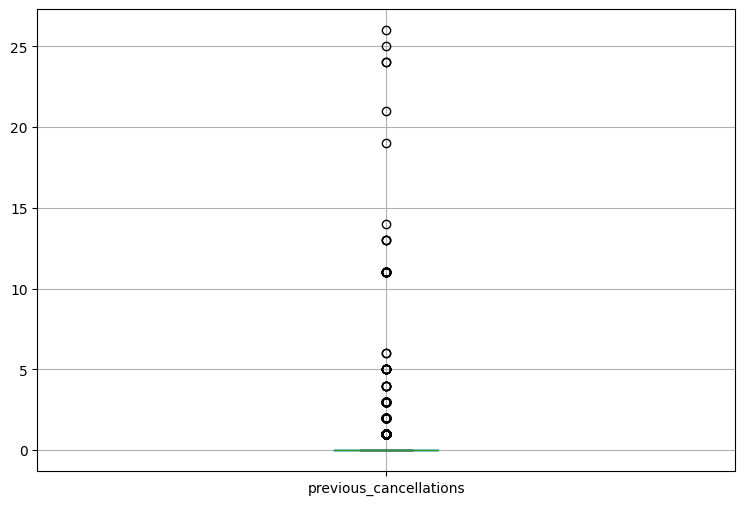

In [53]:
# для обучающей выборки
hotel_train.boxplot(
    column='previous_cancellations',
    figsize=FIGSIZE_FOR_SINGLE_PLOT);

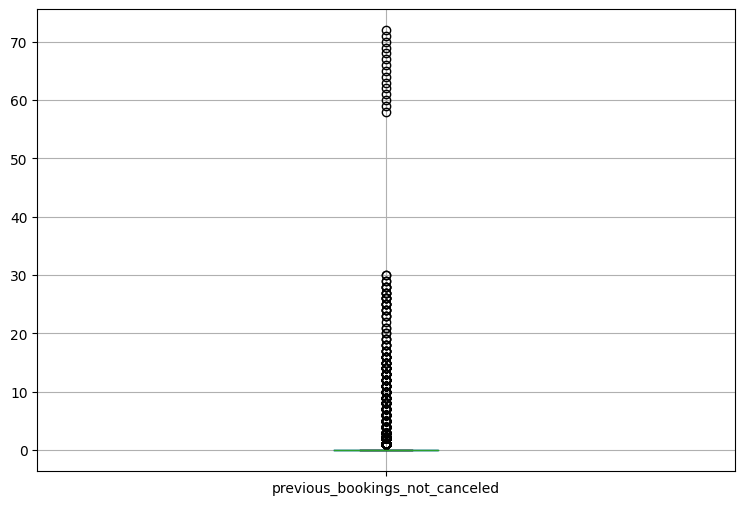

In [54]:
# для тестовой выборки
hotel_test.boxplot(
    column='previous_bookings_not_canceled',
    figsize=FIGSIZE_FOR_SINGLE_PLOT);

In [55]:
# процент от общего числа строк
# для обучающей выборки
hotel_train[
    hotel_train['previous_bookings_not_canceled'] > 20
]['id'].count() / hotel_train.shape[0] * 100

0.13910425978290614

In [56]:
# процент от общего числа строк
# для тестовой выборки
hotel_test[
    hotel_test['previous_bookings_not_canceled'] > 20
]['id'].count() / hotel_test.shape[0] * 100

0.19032192751569144

В случае с количеством отменённых заказов у клиента, видим, что в тестовой выборке верхняя граница диапазона значений даже выше, чем у тренировочной. Данные оставляем.

##### Количество младенцев

Посмотрим количество младенцев в данных.

In [57]:
# для обучающей выборки
hotel_train['babies'].value_counts()

0     43403
1       444
2         3
10        1
9         1
Name: babies, dtype: int64

In [58]:
# для тестовой выборки
hotel_test['babies'].value_counts()

0    24521
1      170
2        4
Name: babies, dtype: int64

Строки, в которых младенцев больше 8, относятся к выбросам. Так как в тестовой выборке мы таких данных не видим, то скорее всего здесь ошибка. Удалим эти строки из тренировочной выборки.

In [59]:
hotel_train.shape

(43852, 25)

In [60]:
# удаляем строки и проверяем размерность
hotel_train = hotel_train[hotel_train['babies'] < 8]
hotel_train.shape

(43850, 25)

##### Необходимость места для автомодиля

In [61]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43850 entries, 0 to 43851
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              43850 non-null  int64 
 1   is_canceled                     43850 non-null  int64 
 2   lead_time                       43850 non-null  int32 
 3   arrival_date_year               43850 non-null  int64 
 4   arrival_date_month              43850 non-null  object
 5   arrival_date_week_number        43850 non-null  int64 
 6   arrival_date_day_of_month       43850 non-null  int64 
 7   stays_in_weekend_nights         43850 non-null  int64 
 8   stays_in_week_nights            43850 non-null  int64 
 9   adults                          43850 non-null  int32 
 10  children                        43850 non-null  int32 
 11  babies                          43850 non-null  int32 
 12  meal                            43850 non-null

In [62]:
# для обучающей выборки
hotel_train['required_car_parking_spaces'].value_counts()

0    40251
1     3587
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

In [63]:
# для тестовой выборки
hotel_test['required_car_parking_spaces'].value_counts()

0    23246
1     1440
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

Посмотрим, сколько человек вселяются в номер в тех строках, где требуется 8 парковочных мест для машин. 

In [64]:
hotel_test[hotel_test['required_car_parking_spaces'] == 8]['adults']

2107    2
2108    2
Name: adults, dtype: int32

В данных строках явно содержится ошибка, удалим их.

In [65]:
hotel_test.shape

(24695, 25)

In [66]:
# удаляем строки и проверяем размерность
hotel_test = hotel_test[hotel_test['required_car_parking_spaces'] < 8]
hotel_test.shape

(24693, 25)

### Проверка данных на адекватность

Проверим, присутствуют ли записи, в которых дети путешествуют без взрослых.

In [67]:
# для обучающей выборки
# дети от 3 до 14
hotel_train[hotel_train['children'] > 0]['adults'].value_counts()

2    3016
1     181
0     149
3      35
Name: adults, dtype: int64

In [68]:
# младенцы
hotel_train[hotel_train['babies'] > 0]['adults'].value_counts()

2    437
1      4
3      3
0      3
Name: adults, dtype: int64

Так как дети и младенцы не могут путешествовать без сопровождения взрослых, удалим эти строки, как содержащие ошибку.

In [69]:
hotel_train.shape

(43850, 25)

In [70]:
# удаляем строки и проверяем размерность
hotel_train = hotel_train.loc[~((hotel_train['adults'] == 0) & (hotel_train['children'] > 0))]
hotel_train = hotel_train.loc[~((hotel_train['adults'] == 0) & (hotel_train['babies'] > 0))]

In [71]:
hotel_train.shape

(43701, 25)

In [72]:
hotel_train[hotel_train['babies'] > 0]['adults'].value_counts()

2    437
1      4
3      3
Name: adults, dtype: int64

In [73]:
# для тестовой выборки
# дети от 3 до 14
hotel_test[hotel_test['children'] > 0]['adults'].value_counts()

2    1745
1     139
0      58
3      26
Name: adults, dtype: int64

In [74]:
# младенцы
hotel_test[hotel_test['babies'] > 0]['adults'].value_counts()

2    170
1      3
3      1
Name: adults, dtype: int64

In [75]:
hotel_test.shape

(24693, 25)

In [76]:
# удаляем строки, нде дели от 3 до 14 путешествуют без взрослых
# и проверяем размерность
hotel_test = hotel_test.loc[~((hotel_test['adults'] == 0) & (hotel_test['children'] > 0))]
hotel_test.shape

(24635, 25)

Все строки с ошибками удалены корректно.

Теперь проверим, для всех ли строк сумма ночей пребывания в будни и на выхъодных равна общему количеству ночей, на которые снят номер.

In [77]:
# количество строк, в которых сумма ночей в будни и выходные не совпадает с общим количеством ночей
# для обучающей выборки
hotel_train[hotel_train['stays_in_weekend_nights'] + hotel_train['stays_in_week_nights'] !=\
hotel_train['total_nights']]['id'].count()

0

In [78]:
# для тестовой  выборки
hotel_test[hotel_test['stays_in_weekend_nights'] + hotel_test['stays_in_week_nights'] !=\
hotel_test['total_nights']]['id'].count()

0

Раз таких строк нет, то при обучении модели можно оставить только данные столбца total_nights, остальные два не использовать, потому что они содержат дублирующую информацию.Раз таких строк нет, то при обучении модели можно оставить только данные столбца total_nights, остальные два не использовать, потому что они содержат дублирующую информацию.

### Вывод


Данные доступны нам в двух датасетах. Пропусков и дубликатов нет. Для проведения анализа данных и последующего использования их для обучения модели потребовалась предварительная обработка. Она проводилась для обоих наборов данных параллельно, чтобы к тому моменту, когда будут переданы модели, они имели одинаковую структуру.

В ходе предварительной обработки:

- столбцы 'lead_time', 'adults', 'children', 'babies' приведели к типу int, так как они содержат целые числа;

- столбец с названиями месяцев был переведен из строкового в числовой. Для этого заменили имена месяцев их порядковым номером в году;

- в столбце, содержащем информацию о типе комнаты, удалили лишние пробелы;

- среди значений столбца 'meal' были исправлены неявные дубликаты (удалены  лишние пробелы);

- проведен анализ выбросов. Часть данных решено оставить, так как это не ошибки данных, а значения, которые могут встречаться и после запуска модели в работу. Строки, содержащие аномальные значения, удалены

- данные проверены на адекватность. Нестыкущиеся данные удалены, принято решение не использовать две из 24х характристик при обучении модели, так как они содержат избыточные данные.


## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Нам требуется обучить модель, которая предскажет нам, откажется ли клиент от брони номера или нет. В случае, если модель предсказывает отказ, клиенту предлагается внести депозит, который составляет 80% от стоимости номера за одни сутки и затрат на разовую уборку.

Чтобы оценить эффективность такой модели, нам необходимо сравнить прибыль отеля без внесения депозита и с ним.

Для этого для каждой строки данных проведем промежуточные вычисления. 

Создадим столбцы, которые будут содержать:

- сезонную наценку номера для каждого конкретного посещения, 

- сумму, которую должен будет заплатить посетитель на проживание в номере,

- расходы, которые понесет отель (в случае, если клиент воспользуется услугами отеля, и в случае, если отменит бронь).

- размер депозита

- прибыль (в том числе и убытки) отеля


### Сезонный коэффициент

Добавим столбец, в котором будет содержаться сезонный коэффициент в зависимости от месяца посещения отеля.

In [79]:
def get_seasonal_coefficient(month):
    '''
    функция по номеру месяца определяет время года 
    и записывает соответствующий коэффициент согласно ценовой политике отеля.
    '''
    if month in [1, 2, 12]:
        return SEASONAL_COEFFICIENT['winter']
    elif month in [3, 4, 5, 9, 10, 11]:
        return SEASONAL_COEFFICIENT['spr_aut']
    else: return SEASONAL_COEFFICIENT['summer']

In [80]:
# добавляем сезонный коэффициент в обучающую выборку
hotel_train['season_coeff'] = hotel_train['arrival_date_month'].apply(get_seasonal_coefficient)

In [81]:
# добавляем сезонный коэффициент в тестовую выборку
hotel_test['season_coeff'] = hotel_test['arrival_date_month'].apply(get_seasonal_coefficient)

In [82]:
# проверяем правильность заполнения
hotel_train['season_coeff'].unique(), hotel_test['season_coeff'].unique()

(array([1.4, 1.2, 1. ]), array([1. , 1.2, 1.4]))

In [83]:
# проверяем наличие необработанных строк
hotel_train['season_coeff'].isna().sum(), hotel_test['season_coeff'].isna().sum()

(0, 0)

### Расчет затрат клиента

Вычислим сумму, которую должен будет заплатить посетитель на проживание в номере.

In [84]:
def count_living_cost(row):
    '''
    функция по общему количеству ночей, типу номера и сезону заезда
    вычисляет размер счета, который будет выставлен клиенту
    '''
    return row['total_nights'] * (PRICES[row['reserved_room_type']] * row['season_coeff'])

In [85]:
# для обучающей выборки
hotel_train['living_cost'] = hotel_train.apply(count_living_cost, axis=1)

In [86]:
# для тестовой выборки
hotel_test['living_cost'] = hotel_test.apply(count_living_cost, axis=1)

In [87]:
# проверяем наличие необработанных строк
hotel_train['living_cost'].isna().sum(), hotel_test['living_cost'].isna().sum()

(0, 0)

### Расчет затрат отеля

В столбец 'hotel_costs' поместим затраты отеля на уборку номера в зависимости от количества ночей, в течение которых клиент пользовался номером. В случае отмены брони в 'hotel_costs' поместим убытки отеля (стоимость одной ночи с учетом сезонного коэффициента и одной уборки).

In [88]:
def count_hotel_costs(row):
    '''вычисляет затраты отеля'''
    
    # затраты, если броня отменена
    if row['is_canceled'] == 1:
        return PRICES[row['reserved_room_type']] * row['season_coeff'] \
                + ONE_TIME_SERVICE[row['reserved_room_type']]
    
    # затраты, если клиент пользовался номером
    return ONE_TIME_SERVICE[row['reserved_room_type']] * (1 + row['total_nights'] // 2)

In [89]:
# для обучающей выборки
hotel_train['hotel_costs'] = hotel_train.apply(count_hotel_costs, axis=1)

In [90]:
# для тестовой выборки
hotel_test['hotel_costs'] = hotel_test.apply(count_hotel_costs, axis=1)

In [91]:
# проверяем наличие необработанных строк
hotel_train['hotel_costs'].isna().sum(), hotel_test['hotel_costs'].isna().sum()

(0, 0)

### Расчет депозита

Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

In [92]:
def count_deposit(row):
    '''вычисляет размер депозита'''
    return (PRICES[row['reserved_room_type']] * row['season_coeff'] \
                + ONE_TIME_SERVICE[row['reserved_room_type']]) * DEPOSIT_PERCENT

In [93]:
# для обучающей выборки
hotel_train['deposit'] = hotel_train.apply(count_deposit, axis=1)

In [94]:
# для тестовой выборки
hotel_test['deposit'] = hotel_test.apply(count_deposit, axis=1)

In [95]:
# проверяем наличие необработанных строк
hotel_train['deposit'].isna().sum(), hotel_test['deposit'].isna().sum()

(0, 0)

### Расчет прибыли отеля

Для расчета прибыли отеля нам нужно от той суммы, которую заплатил клиент за номер (хранится в столбце living_cost) вычесть расходы на обслуживание номера, то есть издержки отеля (hotel_costs).

Если клиент отменил бронь, то прибыль отрицательная (убыток) и равна сумме издержек отеля (хранится в столбце hotel_costs).


Таким образом, если в is_canceled хранится 0, то сумму из living_cost нужно умножать на 1 (брать как есть), а если в is_canceled хранится 1, то сумму из living_cost нужно умножать на 0 (она не берется, так как не получена отелем). Я подобрала функцию, которая переводит 0 в 1, а 1 в 0, т.е. f(0)=1, f(1)=0. Она имеет вид f(x) = 0 ** x. Это позволило рассчитать столбец income без создания дополнительных функций.

In [96]:
# для обучающей выборки
hotel_train['income'] = \
hotel_train['living_cost'] * (0 ** hotel_train['is_canceled'])\
- hotel_train['hotel_costs']

In [97]:
# для тестовой выборки
hotel_test['income'] = \
hotel_test['living_cost'] * (0 ** hotel_test['is_canceled'])\
- hotel_test['hotel_costs']

In [98]:
# проверяем наличие необработанных строк
hotel_train['income'].isna().sum(), hotel_test['income'].isna().sum()

(0, 0)

Посмотрим, как выглядят данные с новыми столбцами.

In [99]:
# для обучающей выборки
hotel_train[
    ['is_canceled', 
     'reserved_room_type', 
     'arrival_date_month',
     'total_nights', 
     'season_coeff', 
     'living_cost', 
     'hotel_costs',
     'deposit',
     'income'
    ]
].head(5)

,is_canceled,reserved_room_type,arrival_date_month,total_nights,season_coeff,living_cost,hotel_costs,deposit,income
0,0,A,7,1,1.4,1400.0,400.0,1440.0,1000.0
1,0,A,7,2,1.4,2800.0,800.0,1440.0,2000.0
2,0,C,7,2,1.4,1680.0,700.0,952.0,980.0
3,0,C,7,2,1.4,1680.0,700.0,952.0,980.0
4,1,A,7,3,1.4,4200.0,1800.0,1440.0,-1800.0


In [100]:
# для тестовой выборки
hotel_test[
    ['is_canceled', 
     'reserved_room_type', 
     'arrival_date_month',
     'total_nights', 
     'season_coeff', 
     'living_cost', 
     'hotel_costs',
     'deposit',
     'income'
    ]
].head(5)

,is_canceled,reserved_room_type,arrival_date_month,total_nights,season_coeff,living_cost,hotel_costs,deposit,income
0,1,A,1,1,1.0,1000.0,1400.0,1120.0,-1400.0
1,1,A,1,4,1.0,4000.0,1400.0,1120.0,-1400.0
2,1,A,1,4,1.0,4000.0,1400.0,1120.0,-1400.0
3,1,A,1,7,1.0,7000.0,1400.0,1120.0,-1400.0
4,1,A,1,7,1.0,7000.0,1400.0,1120.0,-1400.0


Вычислим прибыль отеля без введения депозитов:

In [101]:
hotel_train['income'].sum()

66308200.0

Посчитаем издержки отеля из-за отмены брони:

In [102]:
hotel_train[hotel_train['is_canceled'] == 1]['income'].sum()

-15121010.0

### Вывод

Для вычисления прибыли отеля мы создали столбцы, которые содержат:

- сезонную наценку номера для каждого конкретного посещения,
- сумму, которую должен будет заплатить посетитель на проживание в номере,
- расходы, которые понесет отель (в случае, если клиент воспользуется услугами отеля, и в случае, если отменит бронь).
- размер депозита
- прибыль (в том числе и убытки) отеля

До разработки модели **прибыль отеля без введения депозитов составляет**

**66 308 200 рублей**.

При этом **издержки отеля из-за отмены брони составили**

**15 121 010 рублей**.


## Шаг 4. Разработка модели ML

Для разработки модели машинного обучения:
- обработаем категориальные признаки, значения которых имеют строковый тип;
- создадим переменные, содержащие характеристики наблюдений и целевой признак;
- проведем масштабирование характеристик;
- с помощью кросс-валидации обучим и оценим несколько моделей;
- выберем лучшую модель.


### Обработка категориальных признаков

Создадим список категориальных признаков.

In [103]:
OBJECT_COLUMNS_LIST = ['meal', 
                       'country', 
                       'distribution_channel', 
                       'reserved_room_type', 
                       'customer_type'
                      ]

Посмотрим на значения признаков для обучающей выборки.

In [104]:
for column in OBJECT_COLUMNS_LIST:
    print('признак', column, 'содержит', len(hotel_train[column].unique()), 'уникальных значений:')
    print(sorted(hotel_train[column].unique()))

признак meal содержит 4 уникальных значений:
['BB', 'FB', 'HB', 'SC']
признак country содержит 155 уникальных значений:
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ATA', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'BWA', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYM', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GGY', 'GIB', 'GLP', 'GNB', 'GRC', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KHM', 'KNA', 'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MUS', 'MWI', 'MYS', 'NAM', 'NGA', 'NIC', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'POL', 'PRI', 'PRT', 'PRY', 'PYF', 'QAT', 'ROU', 'RUS', 'RWA', 'SAU', 'SEN'

Посмотрим на значения признаков для тестовой выборки.

In [105]:
for column in OBJECT_COLUMNS_LIST:
    print('признак', column, 'содержит', len(hotel_test[column].unique()), 'уникальных значений:')
    print(sorted(hotel_test[column].unique()))

признак meal содержит 4 уникальных значений:
['BB', 'FB', 'HB', 'SC']
признак country содержит 143 уникальных значений:
['ABW', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'ASM', 'ATA', 'ATF', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BRA', 'CAF', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FRA', 'FRO', 'GAB', 'GBR', 'GHA', 'GIB', 'GNB', 'GRC', 'GTM', 'HKG', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KIR', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO', 'MDG', 'MDV', 'MEX', 'MLT', 'MNE', 'MOZ', 'MRT', 'MUS', 'MYS', 'MYT', 'NCL', 'NGA', 'NLD', 'NOR', 'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'POL', 'PRI', 'PRT', 'PRY', 'QAT', 'ROU', 'RUS', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 'SLV', 'SRB', 'STP', 'SUR', 'SVK', 'SVN', 'SWE', 'SYC'

Преобразуем категориальные признаки в численные с помощью техники прямого кодирования (One-Hot Encoding).

In [106]:
# для обучающей выборки
hotel_train = pd.get_dummies(
    hotel_train, 
    columns=['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type'], 
    drop_first=True
)

In [107]:
# для тестовой выборки
hotel_test = pd.get_dummies(
    hotel_test, 
    columns=['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type'], 
    drop_first=True
)

Посмотрим на размерности полученных переменных.

In [108]:
hotel_train.shape, hotel_test.shape

((43701, 194), (24635, 182))

Видим, что количество столбцов отличается. Причина в том, что в двух выборках количество уникальных значений признака meal разное.

Выясним, наличием каких столбцов отличаются наши наборы данных.

In [109]:
# списки названий столбцов
train_columns = hotel_train.columns
test_columns = hotel_test.columns

# список столбцов, отсутствующих в тестовой выборке
list_of_absent_in_test = []
for column in train_columns:
    if column not in test_columns:
        list_of_absent_in_test.append(column)

# список столбцов, отсутствующих в обучающей выборке
list_of_absent_in_train = []
for column in test_columns:
    if column not in train_columns:
        list_of_absent_in_train.append(column)

print(
    'список столбцов, отсутствующих в тестовой выборке содержит', 
    len(list_of_absent_in_test), 
    'названий:'
)
print(list_of_absent_in_test)
print(
    'список столбцов, отсутствующих в обучающей выборке содержит', 
    len(list_of_absent_in_train),
    'названий:'
)
print(list_of_absent_in_train)

список столбцов, отсутствующих в тестовой выборке содержит 31 названий:
['country_ARM', 'country_BDI', 'country_BFA', 'country_BOL', 'country_BRB', 'country_BWA', 'country_CYM', 'country_DMA', 'country_GEO', 'country_GGY', 'country_GLP', 'country_GUY', 'country_HND', 'country_KHM', 'country_KNA', 'country_LCA', 'country_MKD', 'country_MLI', 'country_MMR', 'country_MWI', 'country_NAM', 'country_NIC', 'country_OMN', 'country_PLW', 'country_PYF', 'country_RWA', 'country_SMR', 'country_TMP', 'country_UGA', 'country_VGB', 'country_ZMB']
список столбцов, отсутствующих в обучающей выборке содержит 19 названий:
['country_ASM', 'country_ATF', 'country_BHS', 'country_CAF', 'country_FJI', 'country_FRO', 'country_GHA', 'country_GTM', 'country_KIR', 'country_LAO', 'country_MDG', 'country_MRT', 'country_MYT', 'country_NCL', 'country_NPL', 'country_SDN', 'country_SLE', 'country_TGO', 'country_UMI']


Создадим отсутствующие столбцы в датасетах и заполним их нулями

In [110]:
# для обучающей выборки
hotel_train[list_of_absent_in_train] = 0

# для тестовой выборки
hotel_test[list_of_absent_in_test] = 0

In [111]:
# проверим размерности
hotel_train.shape, hotel_test.shape

((43701, 213), (24635, 213))

Теперь размерности совпадают. Посмотрим списки столбцов в наборах данных.

In [112]:
# для обучающей выборки
hotel_train.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults',
       ...
       'country_LAO', 'country_MDG', 'country_MRT', 'country_MYT',
       'country_NCL', 'country_NPL', 'country_SDN', 'country_SLE',
       'country_TGO', 'country_UMI'],
      dtype='object', length=213)

In [113]:
# для тестовой выборки
hotel_test.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults',
       ...
       'country_NIC', 'country_OMN', 'country_PLW', 'country_PYF',
       'country_RWA', 'country_SMR', 'country_TMP', 'country_UGA',
       'country_VGB', 'country_ZMB'],
      dtype='object', length=213)


Видим, что порядок столбцов не совпадает. Это станет препятствием для работы модели, потому что она обрабатывает данные не как строки текстовой таблицы, а как вектора линейной алгебры. Поэтому изменение порядка следования столбцов равносильно изменению системы координат, а значит сделает невозможным корректное предсказание целевого признака для тестовой выборки.

Исправим это, переставив столбцы тестовой выборки в соответствии с порядком столбцов обучающей выборки.


In [114]:
hotel_test = hotel_test[hotel_train.columns]
hotel_test.columns

Index(['id', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults',
       ...
       'country_LAO', 'country_MDG', 'country_MRT', 'country_MYT',
       'country_NCL', 'country_NPL', 'country_SDN', 'country_SLE',
       'country_TGO', 'country_UMI'],
      dtype='object', length=213)

Теперь обе выборки имеют одинаковую структуру.	

### Разбивка датасетов на характеристики и целевой признак

Посмотрим, насколько сильно коррелируют между собой числа из living_cost, hotel_costs и income.

In [115]:
hotel_train['living_cost'].corr(hotel_train['hotel_costs'])

0.6668901385625635

In [116]:
hotel_train['living_cost'].corr(hotel_train['income'])

0.5120542655881467

In [117]:
hotel_train['hotel_costs'].corr(hotel_train['income'])

-0.040255087737850435

Модуль коэффициента корреляции достаточно высокий, это объясняется способом расчетов этих столбцов, поэтому лучше всего оставить для обучения модели только один из них. Так как на решение об отказе от брони может повлиять общая стоимость проживания в отеле оставим столбец living_cost.

In [118]:
features_train = hotel_train.drop(
    ['id', 
     'is_canceled', 
     'stays_in_weekend_nights', 
     'stays_in_week_nights',
     'hotel_costs', 
     'income', 
     'deposit'],
    axis=1
)
target_train = hotel_train['is_canceled']

In [119]:
features_test = hotel_test.drop(
    ['id', 
     'is_canceled', 
     'stays_in_weekend_nights', 
     'stays_in_week_nights',
     'hotel_costs', 
     'income', 
     'deposit'], 
    axis=1
)
target_test = hotel_test['is_canceled']

### Выбор метрики для обучения

Для данной задачи важно, чтобы модель выявила как можно больше объектов, для которых значение целевого признака равно 1. То есть нам нужно стремиться получить максимально возможное значение полноты (recall).

В случае, если точность модели (precision) будет невысокой, это будет означать, что части клиентов из тех, которые не собирались отменять бронь, будет предложено внести депозит – по факту, внести как предоплату часть той суммы, которую они и так потратят на проживание в отеле.

Поэтому будем выбирать модель, для которой полнота максимальна. Передадим recall в качестве значения параметра scoring при кросс-валидации.


### Выбор модели

С помощью кросс-валидации обучим и оценим модели дерева принятия решений и случайного леса с различными значениями гиперпараметров.

Так как в обучающих данных наблюдается  дисбаланс классов в целевом признаке, будем использовать параметр class_weight со значением balanced при обучении моделей. 

##### Дерево решений

In [120]:
# параметры самой лучшей модели
best_tree_model = None
best_result = 0

# цикл для подбора максимальной глубины
for depth in range(1, 10):
    for crit in ['gini', 'entropy']:
        for split in ['best', 'random']:

            model_decison_tree = DecisionTreeClassifier(
                max_depth=depth,
                criterion=crit,
                splitter=split,
                random_state=RANDOM_STATE,
                class_weight='balanced'
            )

            # обучение и оценка модели с помощью кросс-валидации
            decison_tree_scores = cross_val_score(
                model_decison_tree, 
                features_train, 
                target_train, 
                cv=5,
                scoring='recall'
            )

            print('model:', model_decison_tree)
            print('scores', decison_tree_scores)
            print('mean score', decison_tree_scores.mean())
            print()

            # если показатели текущей модели лучшие на данный момент, сохраним их
            if decison_tree_scores.mean() > best_result:
                best_result = decison_tree_scores.mean()
                best_tree_model = model_decison_tree
print()
print('-------------------------------------')

# вывод параметров и оценок лучшей модели
print('Best results:')
print('model:', best_tree_model)
print('mean score', best_result)

model: DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=12345)
scores [0.92657658 0.8472973  1.         0.94774775 0.8990991 ]
mean score 0.9241441441441441

model: DecisionTreeClassifier(class_weight='balanced', max_depth=1, random_state=12345,
                       splitter='random')
scores [1.         0.49279279 1.         0.20945946 0.87927928]
mean score 0.7163063063063063

model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, random_state=12345)
scores [1.        0.8472973 1.        1.        1.       ]
mean score 0.9694594594594594

model: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, random_state=12345, splitter='random')
scores [1.         0.49279279 1.         0.20945946 0.87927928]
mean score 0.7163063063063063

model: DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=12345)
scores [0.52837838 0.43558559 0.2531

##### Случайный лес

In [121]:
# параметры самой лучшей модели
best_forest_model = None
best_result = 0

# цикл для подбора количества деревьев в лесу, глубины и функцтт оценки качества разбиения
for estimators in range(10, 50, 10):
    for depth in range(1, 10):
        for crit in ['gini', 'entropy']:

            model_random_forest = RandomForestClassifier(
                n_estimators=estimators,
                max_depth=depth,
                criterion=crit,
                random_state=RANDOM_STATE,
                class_weight='balanced'
            )

            # обучение и оценка модели с помощью кросс-валидации
            random_forest_scores = cross_val_score(
                model_random_forest, 
                features_train, 
                target_train, 
                cv=5,
                scoring='recall'
            )
            print('model:', model_random_forest)
            print('scores', random_forest_scores)
            print('mean score', random_forest_scores.mean())
            print()

            # если показатели текущей модели лучшие на данный момент, сохраним их
            if random_forest_scores.mean() > best_result:
                best_result = random_forest_scores.mean()
                best_forest_model = model_random_forest
print()
print('-------------------------------------')

# вывод параметров и оценок лучшей модели
print('Best results:')
print('model:', best_forest_model)
print('mean score', best_result)

model: RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10,
                       random_state=12345)
scores [0.67747748 0.39144144 0.21846847 0.23738739 0.72837838]
mean score 0.4506306306306306

model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, n_estimators=10, random_state=12345)
scores [0.67747748 0.41351351 0.21846847 0.23738739 0.72837838]
mean score 0.455045045045045

model: RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=10,
                       random_state=12345)
scores [0.81396396 0.44414414 0.30945946 0.26396396 0.72072072]
mean score 0.5104504504504505

model: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=2, n_estimators=10, random_state=12345)
scores [0.81396396 0.42612613 0.30945946 0.26396396 0.72072072]
mean score 0.5068468468468469

model: RandomForestClassifier(class_weight='balanced', max_depth=3,

##### Вывод

По результатам кросс-валидации, лучшие показатели у модели дерева принятия решений со следующими значениями гиперпараметров:

DecisionTreeClassifier(
class_weight='balanced', 
criterion='entropy',
max_depth=1, 
random_state=12345)
Средняя оценка полноты составляет 0.9695


### Обучение модели и проверка ее на тестовой выборке

Обучим модель на тренировочной выборке.

In [122]:
model = DecisionTreeClassifier(
    class_weight='balanced', 
    criterion='entropy',
    max_depth=1, 
    random_state=12345
)

model.fit(features_train, target_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=1, random_state=12345)

Вычислим предсказания модели на тестовой выборке и оценим их качество.

In [123]:
predictions = model.predict(features_test)

In [124]:
# полнота
recall_score(target_test, model.predict(features_test))

1.0

In [125]:
# точность
precision_score(target_test, predictions)

0.3345120531286386

In [126]:
# доля правильных ответов
accuracy_score(target_test, predictions)

0.37357418307286383

У выбранной модели на тестовой выборке высокая полнота (1.00). Это говорит о том, что практически все клиенты, отказывающиеся от брони будут идентифицированы правильно.

Вычислим, как применение модели повлияет на доходы отеля.

### Оценка прибыли от модели за тестовый период

Рассчитаем прибыль на тестовой выборке без введения депозита и использования модели и с введением депозита по предсказаниям модели.

In [127]:
def count_income_with_deposit(predictions, data):
    '''
    рассчитывает прибыль c использованием предсказаний модели.
    Принимает на вход следующие параметры:
    predictions - Series c предсказаниями модели
    data - изначальные данные

    '''
    # часть данных, в которых по предсказаниям модели произойдет отказ от брони
    predicted_cancellations = data.iloc[predictions[predictions == 1].index]
    
    # те из predicted_cancellations, в которых на самом произойдет отказ от брони
    truely_predicted_cancellations = predicted_cancellations[
        predicted_cancellations['is_canceled'] == 1
    ]
    
    # если модель предсказала отказ от брони, и он произошёл, 
    # отель несет убытки в размере 20% от стоимости одной ночи (с учетом сезонного кожффицента) и одной уборки
    # остальные 80% затрат отеля покрывает депозит
    loss_with_deposit = 0 - truely_predicted_cancellations['deposit'].sum() / 4
    
    # если модель предсказала отказ от брони, а он не произошёл, 
    # отелю остается доход от пребывания клиента (хранится в столбце income)
    wrongly_predicted_cancellations = predicted_cancellations[
        predicted_cancellations['is_canceled'] == 0
    ]
    income = wrongly_predicted_cancellations['income'].sum()
    
    # если модель предсказала, что отказа от брони не будет, 
    # то отель либо получает доход от пребывания клиента (хранится в столбце income) 
    # либо терпит убытки о того, что не внесен депозит (также хранится в столбце income).
    
    # часть данных, в которых по предсказаниям модели не будет отказа от брони
    predicted_confirmations = data.iloc[predictions[predictions == 0].index]
    confirmations_income = predicted_confirmations['income'].sum()
    
    # Общая прибыль отеля
    income_with_deposit = loss_with_deposit + income + confirmations_income
    return income_with_deposit

In [128]:
# прибыль без использования модели 
income_without_deposit = hotel_test['income'].sum()
income_without_deposit

32624960.0

In [129]:
# прибыль c с введением депозита по предсказаниям модели 
income_with_deposit = count_income_with_deposit(pd.Series(predictions), hotel_test)
income_with_deposit

41052776.0

In [130]:
# выгода от использования модели
income_with_deposit - income_without_deposit

8427816.0

Прибыль на тестовой выборке без использования модели и введения депозита составляет 32 624 960 рублей.

Прибыль с использованием модели и введением депозита составляет 41 052 776 рублей.

Выгода от использования модели составляет 8 427 816 рублей.


### Выводы

Для разработки модели машинного обучения мы:

- обработали категориальные признаки, значения которых имеют строковый тип;
- создали переменные, содержащие характеристики наблюдений и целевой признак;;
- с помощью кросс-валидации обучили и оценили несколько моделей.

По результатам кросс-валидации, лучшие показатели у модели дерева принятия решений со следующими значениями гиперпараметров:

model = DecisionTreeClassifier(
    class_weight='balanced', 
    criterion='entropy',
    max_depth=1, 
    random_state=12345
)

В ходе проверки качества модели на тестовых данных получены следующие характеристики:

полнота 1.00,
точность 0.33,
доля правильных ответов 0.37.

Самая важная для нас оценка - полнота.

Применение модели положительно влияет на доходы отеля.

Прибыль на тестовой выборке без использования модели и введения депозита составляет 32 624 960 рублей.

**Прибыль с использованием модели** и введением депозита составляет **41 052 776 рублей**.

**Выгода от использования модели составляет 8 427 816 рублей**, что <u>покрывает расходы на разработку системы прогнозирования (400 000 рублей)</u>.


## Шаг 5. Опишите портрет «ненадёжного» клиента

Для того, чтобы составить портрет ненадежного клиента, удобно использовать данные в первоначальном виде, такие, как они хранятся в файле «/datasets/hotel_test.csv». 

Для проведения исследовательского анализа выберем из них только те строки, для которых модель предсказывает отказ от брони. 


### Выгрузка и анализ данных

In [132]:
# строки, для которых модель предсказывает отказ от брони
predictions = pd.Series(predictions)
decliners = pd.read_csv('datasets/hotel_test.csv').iloc[predictions[predictions == 1].index]

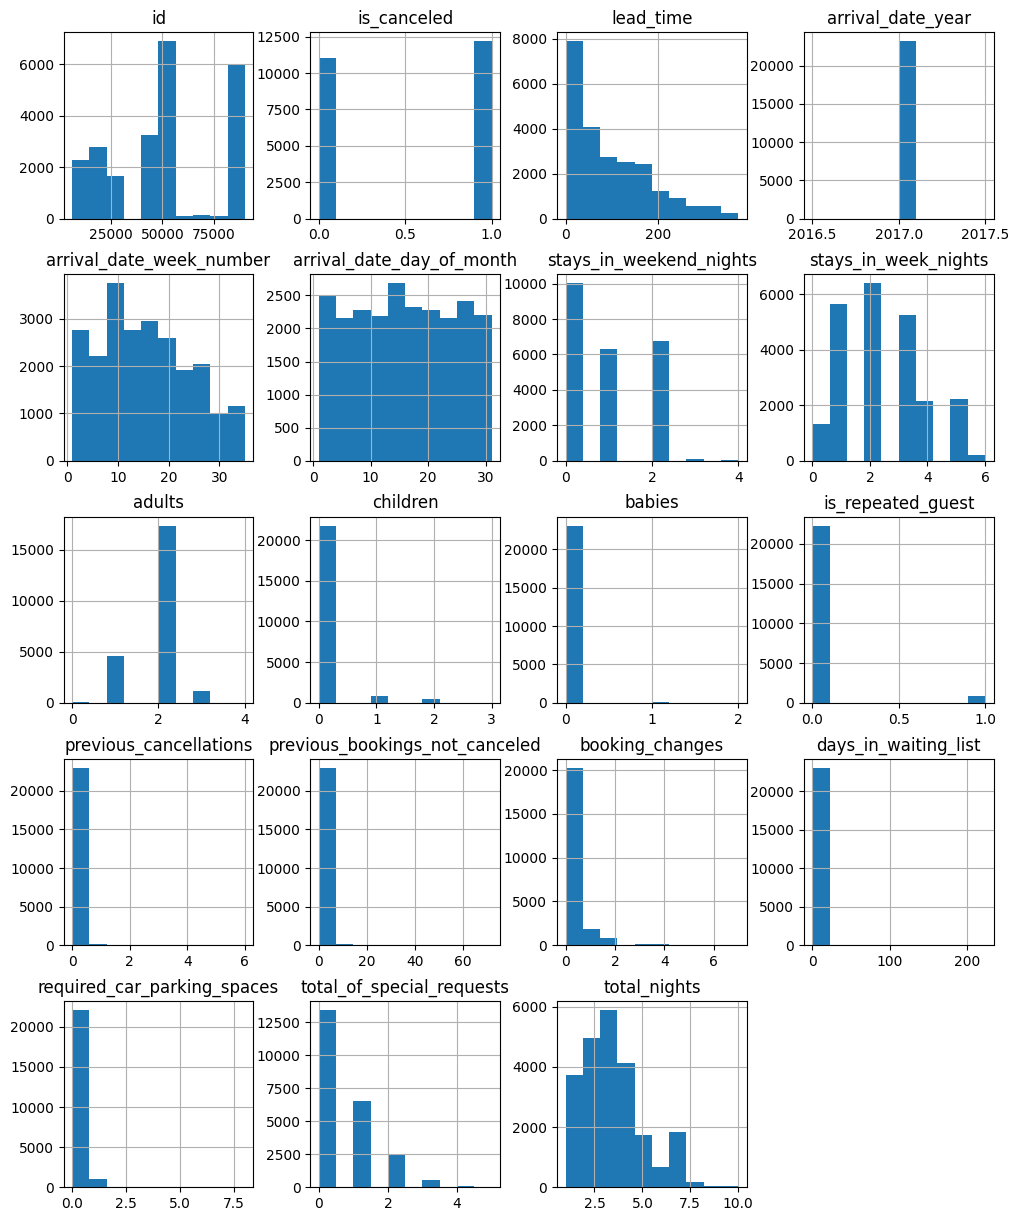

In [133]:
# выведем гистограммы числовых признаков
decliners.hist(figsize=FIGSIZE_FOR_BUNCH_OF_PLOTS);

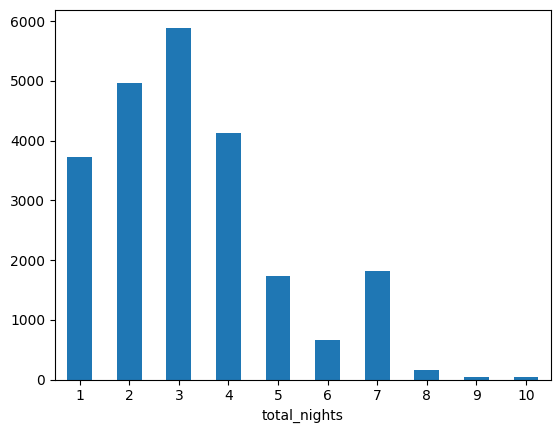

In [134]:
# посмотрим детальнее общее количество ночей, на которые бронировался номер
decliners.groupby('total_nights')['id'].count().plot(
    rot=0, 
    kind='bar'
);

По гистограммам можно сказать, что чаще всего отказываются от брони клиенты, которые путешествуют парой, без детей, раннее услугами данного отеля не пользовались, номер бронировали на две-три ночи без необходимости места для автомобиля.

Перейдем теперь к категориальным признакам.

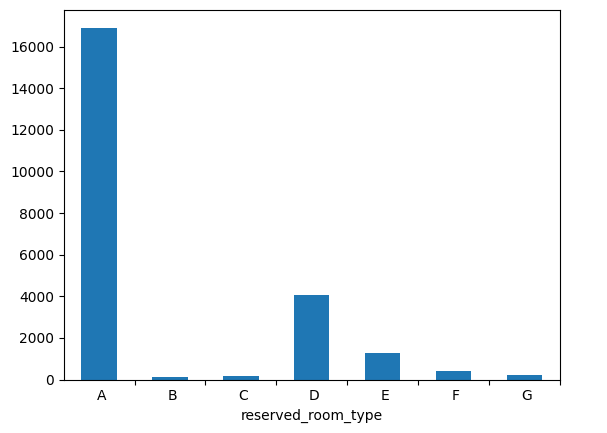

In [135]:
# найдем самый распространенный тип номера
decliners.groupby('reserved_room_type')['id'].count().plot(
    kind='bar', 
    rot=0, 
    position=1.5
);

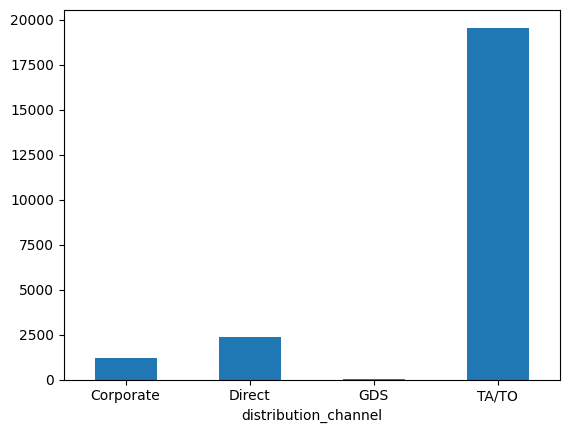

In [136]:
# канал дистрибуции заказа
decliners.groupby('distribution_channel')['id'].count().plot(
    rot=0, 
    kind='bar'
);

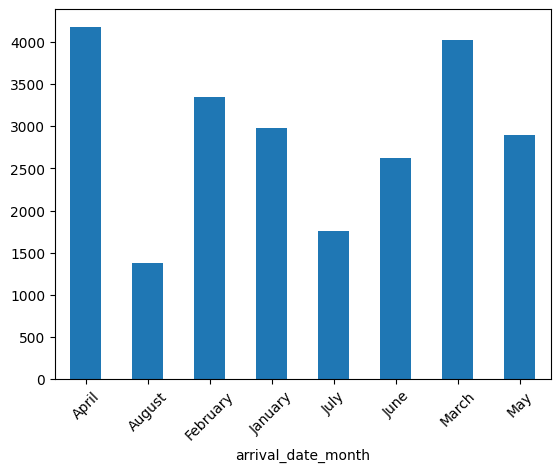

In [137]:
decliners.groupby('arrival_date_month')['id'].count().plot(
    rot=45, 
    kind='bar'
);

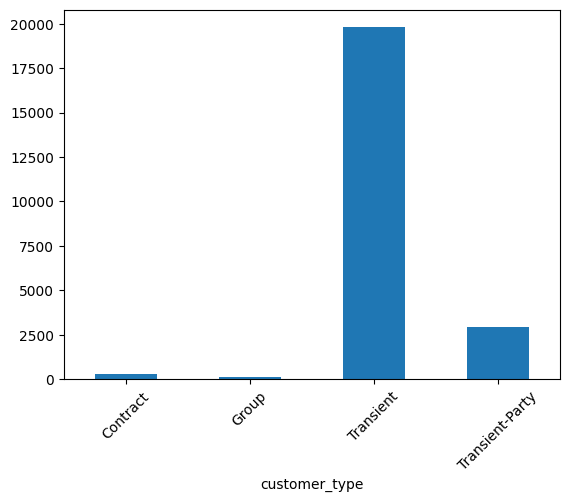

In [138]:
# тип заказчика
decliners.groupby('customer_type')['id'].count().plot(
    rot=45, 
    kind='bar'
);

Посмотри на десятку стран, граждане которых чаще всего отказываются от брони.

In [139]:
decliners['country'].value_counts()[:10]

PRT    8430
GBR    2707
FRA    2170
ESP    1444
DEU    1309
ITA     850
IRL     731
BRA     675
BEL     480
USA     459
Name: country, dtype: int64

На основе анализа категориальных признаков можно сделать вывод, что это туристы путешествующие самостоятельно, бронировали номер категории А через туроператора или турагентство в период с января по апрель.

Десятка стран-лидеров по отказу от брони: Португалия, Великобритания, Франция, Испания, Германия, Италия, Ирландия, Бразилия, Бельгия и США.

### Вывод

Портрет «ненадежного клиента»:
    
- туристы из Португалия, Великобритания, Франция, Испания, Германия, Италия, Ирландия, Бразилия, Бельгия или США., 
- путешествуют парой, 
- без детей, 
- без группового заезда,
- раннее услугами данного отеля не пользовались, 
- бронировали номер категории А, 
- на период с апреля по июнь.
- через туроператора или турагентство,
- на две-три ночи,
- без необходимости места для автомобиля,
- не связано с договором или групповым заездом.

## Шаг 6. Напишите общий вывод

Чтобы привлечь клиентов, сеть отелей «Как в гостях» добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони.
Для решения этой задачи были предоставлены два набора данных – обучающий и тестовый.

Обучающая и тестовая выборки изначально содержали 65229 и 32412 строк соответственно.

После удаления дубликатов - 43852 и 24695 строк.

Для проведения анализа данных и последующего использования их для обучения модели потребовалась предварительная обработка. 

В ходе предварительной обработки:
- изменили типы данных некоторых столбцов
- в столбце, содержащем информацию о типе комнаты, удалили лишние пробелы;
- среди значений столбца 'meal' были исправлены неявные дубликаты (удалены лишние пробелы);
- проведен анализ выбросов. Часть данных решено оставить, так как это не ошибки данных, а значения, которые могут встречаться и после запуска модели в работу. Строки, содержащие аномальные значения, удалены
- данные проверены на адекватность. Нестыкущиеся данные удалены, принято решение не использовать две из 24х характристик при обучении модели.

Для вычисления прибыли отеля мы создали столбцы, которые содержат:
- сезонную наценку номера для каждого конкретного посещения,
- сумму, которую должен будет заплатить посетитель на проживание в номере,
- расходы, которые понесет отель (в случае, если клиент воспользуется услугами отеля, и в случае, если отменит бронь).
- размер депозита
- прибыль (в том числе и убытки) отеля

До разработки модели **прибыль отеля без введения депозитов составляет**

**66 308 200 рублей**.

При этом **издержки отеля из-за отмены брони составили**

**15 121 010 рублей**.

Для разработки модели машинного обучения мы:
- разбили данные на характеристики наблюдений и целевой признак;
- с помощью кросс-валидации обучили и оценили несколько моделей.

По результатам кросс-валидации, лучшие показатели у модели дерева принятия решений со следующими значениями гиперпараметров:

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=12345) <br>
Средняя оценка составляет 0.7689

В ходе проверки качества модели на тестовых данных получены следующие характеристики:

полнота 1.00,
точность 0.33,
доля правильных ответов 0.37.

Самая важная для нас оценка - полнота.

Применение модели положительно влияет на доходы отеля.

Прибыль на тестовой выборке без использования модели и введения депозита составляет 32 624 960 рублей.

**Прибыль с использованием модели** и введением депозита составляет **41 052 776 рублей**.

**Выгода от использования модели составляет 8 427 816 рублей**, что <u>покрывает расходы на разработку системы прогнозирования (400 000 рублей)</u>.

По результатам работы системы прогнозирования был составлен портрет «ненадежного клиента». Это туристы, которые: 
- путешествуют парой, 
- без детей, 
- без группового заезда,
- раннее услугами данного отеля не пользовались, 
- бронировали номер категории А, 
- на период с апреля по июнь.
- через туроператора или турагентство,
- на две-три ночи,
- без необходимости места для автомобиля,
- не связано с договором или групповым заездом.

Десятка стран-лидеров по отказу от брони: Португалия, Великобритания, Франция, Испания, Германия, Италия, Ирландия, Бразилия, Бельгия и США.

По результатам проделанной работы можно рекомендовать сети отелей использовать систему прогнозирования, основанную на модели машинного обучения.
